In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.mplot3d.axes3d as p3
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.transforms import Affine2D
from matplotlib.text import TextPath
import matplotlib.animation as animation
import seaborn as sns
import os
import fnmatch
import helper_functions

%load_ext autoreload
%autoreload 2

helper = helper_functions.HelperFunctions()

data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'
dynamics_data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach/dynamics'
figure_path = 'C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures'

choices = pd.read_csv(os.path.join(data_path, 'choices_processed.txt'))

In [2]:
def get_subj_data(subj_id):
    for root, dirs, files in os.walk(dynamics_data_path):
        for name in files:
            if fnmatch.fnmatch(name, str(subj_id) + '_walking*'):
                return pd.read_csv(os.path.join(dynamics_data_path, name), sep='\t')

In [12]:
choices[(choices.task=='walking') & (choices.max_d<0.2)]

,subj_id,trial_no,task,sequence,is_staircase,ss_delay,ss_amount,ll_delay,ll_amount,is_ss_on_left,...,Delta,Delta_q,max_d,idx_max_d,midline_d,idx_midline_d,midline_d_y,RT,log_RT,is_com
1630,5390,34,walking,wm,False,0,3400,30,5000,False,...,0.22625,High,0.189496,96,0.032861,0,-0.222427,4.026,1.39277,False
1809,5571,32,walking,mw,False,0,3400,30,5000,False,...,-0.52375,Low,0.073992,199,0.050336,0,-0.201283,4.939,1.59716,False
2533,5985,25,walking,wm,True,0,200,30,1600,False,...,0.09375,Medium,0.197915,107,0.000236,18,-0.064130,5.243,1.65689,False


In [15]:
# subj_id = 5813
# trial_no = 46

subj_id = 5390
trial_no = 34

subj_data = get_subj_data(subj_id)
trial_data = subj_data[subj_data.trial_no==trial_no]
# trim the final portion of the data
# trial_data = trial_data.iloc[:int(len(trial_data)*0.8)]
len(trial_data)

154

<IPython.core.display.Javascript object>


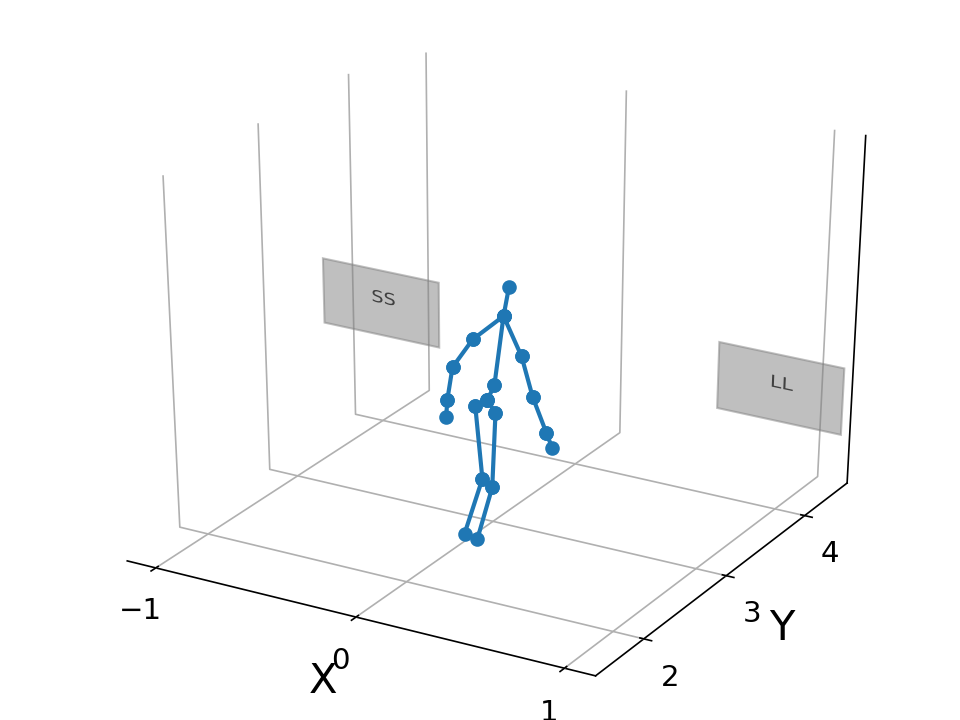

In [16]:
joint_lines = [(1,2), (2,3), (3,4), # spine to head
               (3,5), (5,6), (6,7), (7,8), # right arm
               (3,9), (9,10), (10,11), (11,12), # left arm
               (1,13), (13,14), (14,15),# (15,16), # right leg
               (1,17), (17,18), (18,19)#, (19,20) # left leg
              ]

def text3d(ax, xyz, s, zdir="z", size=None, angle=0, usetex=False, **kwargs):
    '''
    Plots the string 's' on the axes 'ax', with position 'xyz', size 'size',
    and rotation angle 'angle'.  'zdir' gives the axis which is to be treated
    as the third dimension.  usetex is a boolean indicating whether the string
    should be interpreted as latex or not.  Any additional keyword arguments
    are passed on to transform_path.

    Note: zdir affects the interpretation of xyz.
    '''
    x, y, z = xyz
    if zdir == "y":
        xy1, z1 = (x, z), y
    elif zdir == "x":
        xy1, z1 = (y, z), x
    else:
        xy1, z1 = (x, y), z

    text_path = TextPath((0, 0), s, size=size, usetex=usetex)
    trans = Affine2D().rotate(angle).translate(xy1[0], xy1[1])

    p1 = PathPatch(trans.transform_path(text_path), **kwargs)
    ax.add_patch(p1)
    art3d.pathpatch_2d_to_3d(p1, z=z1, zdir=zdir)

def init_lines(ax):
    lines = []
    for joint_line in joint_lines:
        xs = subj_data.iloc[0, [4+3*(joint_line[0]-1)+1, 4+3*(joint_line[1]-1)+1]]
        ys = subj_data.iloc[0, [4+3*(joint_line[0]-1)+3, 4+3*(joint_line[1]-1)+3]]
        zs = subj_data.iloc[0, [4+3*(joint_line[0]-1)+2, 4+3*(joint_line[1]-1)+2]]
        line = ax.plot(xs, ys, zs, color='C0', lw=2, marker='o')
        lines.append(line)
    return lines

def update_lines(num, lines, joint_lines):    
    for i, joint_line in enumerate(joint_lines):
        xs = subj_data.iloc[num, [4+3*(joint_line[0]-1)+1, 4+3*(joint_line[1]-1)+1]]
        ys = subj_data.iloc[num, [4+3*(joint_line[0]-1)+3, 4+3*(joint_line[1]-1)+3]]
        zs = subj_data.iloc[num, [4+3*(joint_line[0]-1)+2, 4+3*(joint_line[1]-1)+2]]
        lines[i][0].set_data(xs, ys)
        lines[i][0].set_3d_properties(zs)

    return lines

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

lines = init_lines(ax)

ax.set_xlim3d(-1.1, 1.1)
ax.set_xlabel('X')

ax.set_ylim3d([1.5, 4.5])
ax.set_ylabel('Y')

ax.set_zlim3d([-1.0, 1.0])

# Hide grid lines
# ax.grid(False)

p = Rectangle(xy=(-1.3, -0.5), width=0.6, height=0.4, alpha=0.5, color='grey')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=4, zdir="y")
text3d(ax, (-1.05, 4, -0.3), 'SS', zdir="y", size=0.1, usetex=False, ec="none", fc="k")

p = Rectangle(xy=(0.7, -0.5), width=0.6, height=0.4, alpha=0.5, color='grey')
ax.add_patch(p)
art3d.pathpatch_2d_to_3d(p, z=4, zdir="y")
text3d(ax, (0.95, 4, -0.3), 'LL', zdir="y", size=0.1, usetex=False, ec="none", fc="k")

# Hide axes ticks
ax.set_xticks([-1, 0, 1])
ax.set_yticks([2, 3, 4])
ax.set_zticks([])


line_ani = animation.FuncAnimation(fig=fig, func=update_lines, #init_func=init_lines, 
                                   frames=len(trial_data)-1, fargs=(lines, joint_lines),
                                   interval=28, blit=False)
ax.auto_scale_xyz([-1.2, 1.2], [1, 4.5], [-1, 1])
plt.show()

# Set up formatting for the movie files
# plt.rcParams['animation.ffmpeg_path'] = 'C:/FFmpeg/bin'
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
line_ani.save('%i_%i.mp4' % (subj_id, trial_no), writer=writer)